Seems relevant: https://gist.github.com/arunaugustine/5551446

In [67]:
import aifc
import numpy as np
import h5py
from matplotlib import pyplot as plt
%matplotlib notebook

# Exploring Data Format

In [36]:
small_folder = "small_data_sample/right_whale/"
small_file_1 = "train12.aiff"

In [37]:
small_aifc_1 = aifc.open(small_folder + small_file_1)

In [38]:
small_aifc_1.getnchannels()

1

In [39]:
small_aifc_1.getframerate()

2000

In [40]:
small_aifc_1.getnframes()

4000

In [41]:
frames = small_aifc_1.readframes(small_aifc_1.getnframes())

In [42]:
array = np.fromstring(frames, np.short).byteswap()
array

array([ 344,  438, -318, ..., -306,   33,  177], dtype=int16)

In [43]:
#array = np.fromstring(frames, 'float64').byteswap()
#array

<IPython.core.display.Javascript object>


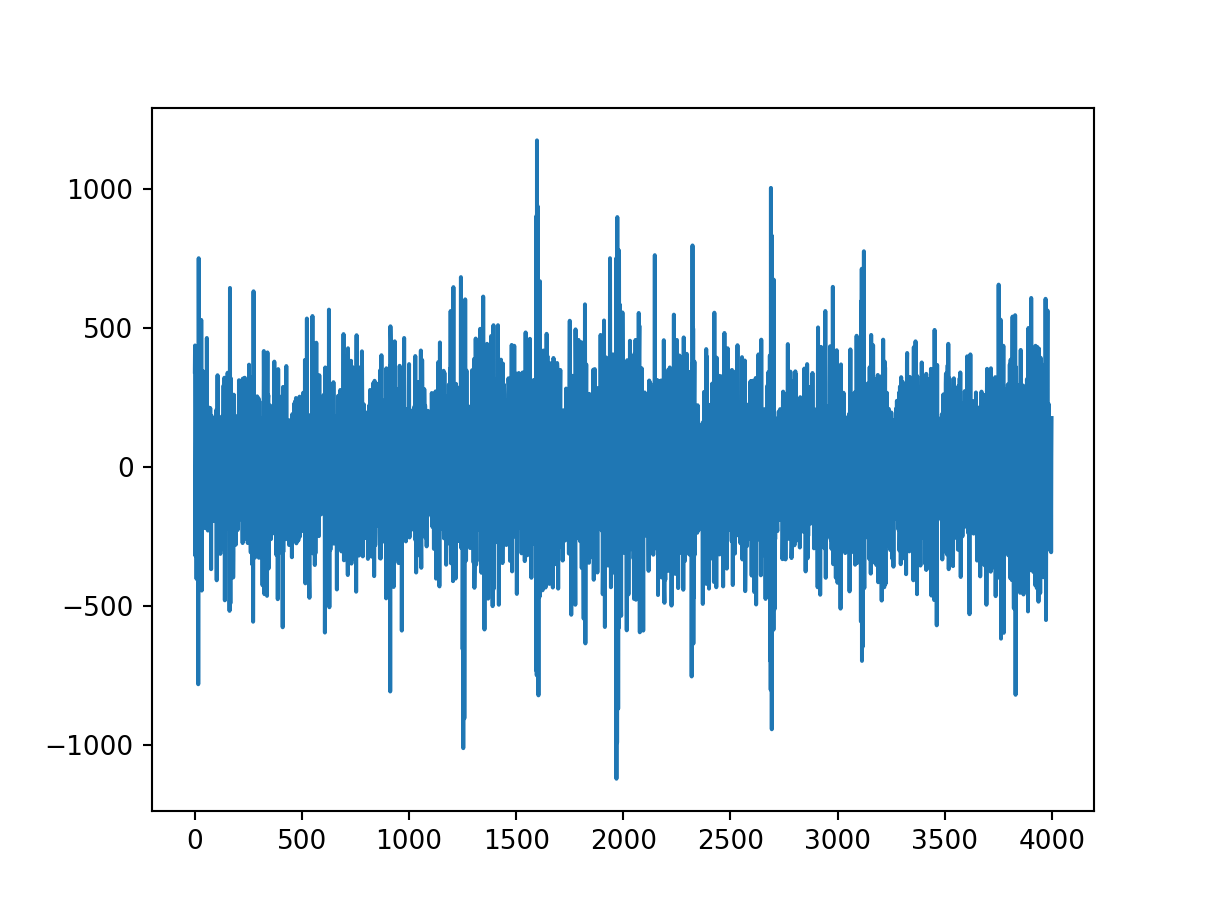

In [44]:
plt.figure()
plt.plot(array)

<IPython.core.display.Javascript object>


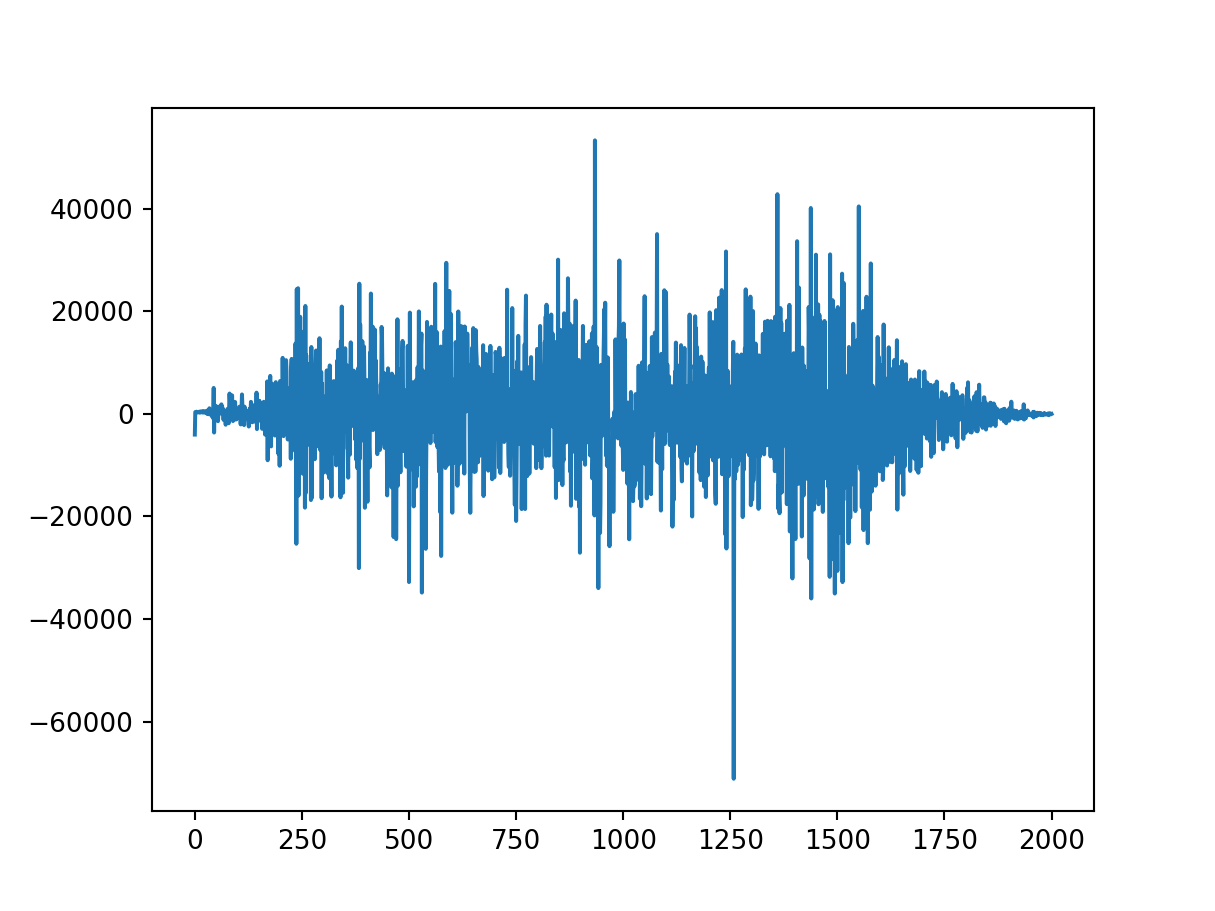

/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [34]:
plt.figure()
plt.plot(np.fft.rfft(array))

In [72]:
whale_files = [
    "small_data_sample/right_whale/train12.aiff",
    "small_data_sample/right_whale/train28.aiff",
    "small_data_sample/right_whale/train6.aiff",
    "small_data_sample/right_whale/train7.aiff",
    "small_data_sample/right_whale/train9.aiff"
]
no_whale_files = [
    "small_data_sample/no_right_whale/train1.aiff",
    "small_data_sample/no_right_whale/train2.aiff",
    "small_data_sample/no_right_whale/train3.aiff",
    "small_data_sample/no_right_whale/train4.aiff",
    "small_data_sample/no_right_whale/train5.aiff"
]

In [73]:
whale_aifcs = []
whale_data = []
for file_name in whale_files:
    whale_aifcs.append(aifc.open(file_name))
for aifc_file in whale_aifcs:
    frames = aifc_file.readframes(aifc_file.getnframes())
    whale_data.append(np.fromstring(frames, np.short).byteswap())
whale_data = np.array(whale_data)

no_whale_aifcs = []
no_whale_data = []
for file_name in no_whale_files:
    no_whale_aifcs.append(aifc.open(file_name))
for aifc_file in no_whale_aifcs:
    frames = aifc_file.readframes(aifc_file.getnframes())
    no_whale_data.append(np.fromstring(frames, np.short).byteswap())
no_whale_data = np.array(no_whale_data)

In [75]:
whale_data, no_whale_data

(array([[ 344,  438, -318, ..., -306,   33,  177],
        [-400,  134,  542, ...,  -31, -333, -444],
        [  42, -486,  -22, ...,  219, -155,  -32],
        [ 292, -154, -930, ..., -536,  147,  242],
        [ 138, -600,   49, ...,   63,  120,    5]], dtype=int16),
 array([[ 303, -140, -166, ...,  194,   65,  402],
        [  74,  200,  -22, ..., -204,  107,  -11],
        [-197,  231,   79, ..., -303,   41,  120],
        [-122,    0,  -33, ...,  -24,  -37,    2],
        [ 292, -258,   44, ...,  155, -512, -300]], dtype=int16))

<IPython.core.display.Javascript object>


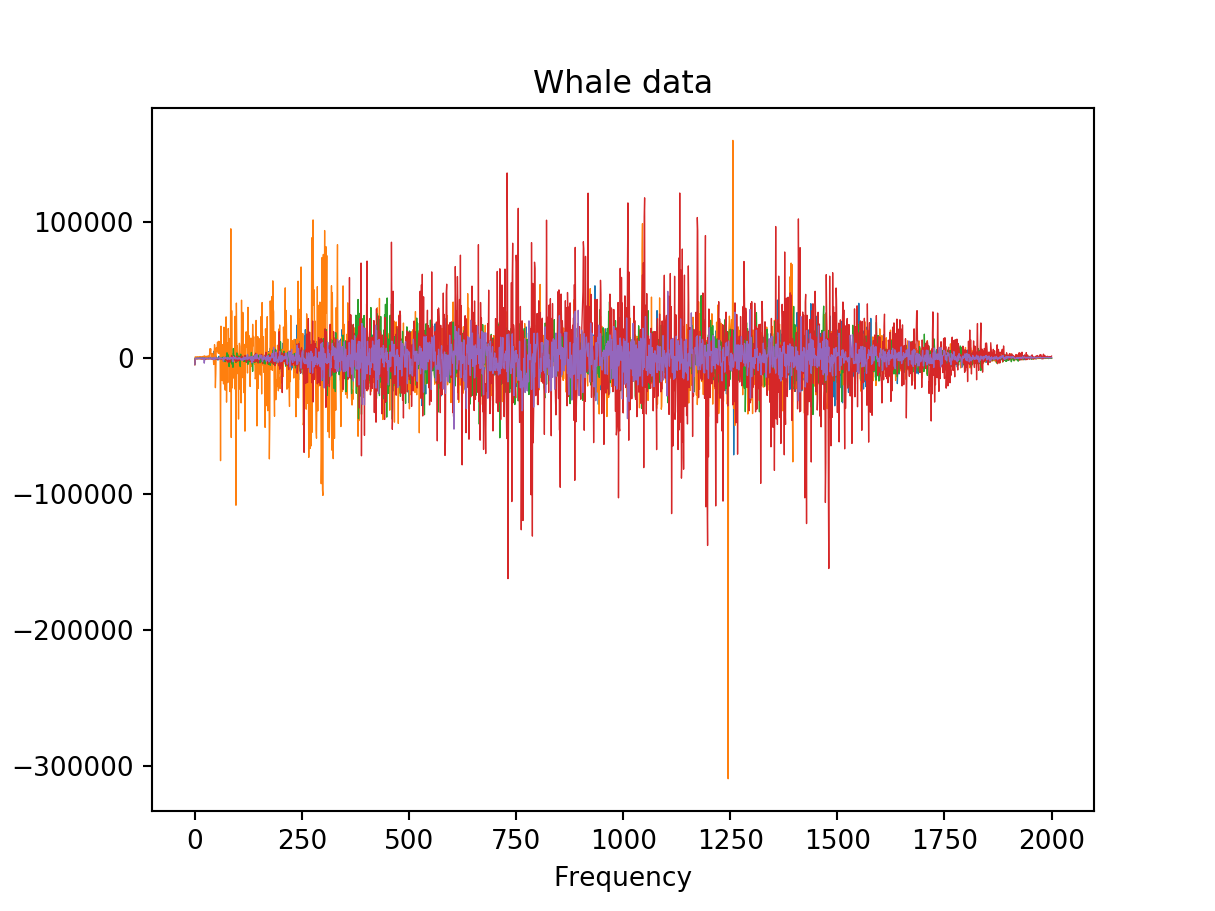

Text(0.5,1,u'Whale data')

In [77]:
plt.figure()
for array in whale_data:
    plt.plot(np.fft.rfft(array), linewidth=0.5)
plt.xlabel('Frequency')
plt.title('Whale data')

<IPython.core.display.Javascript object>


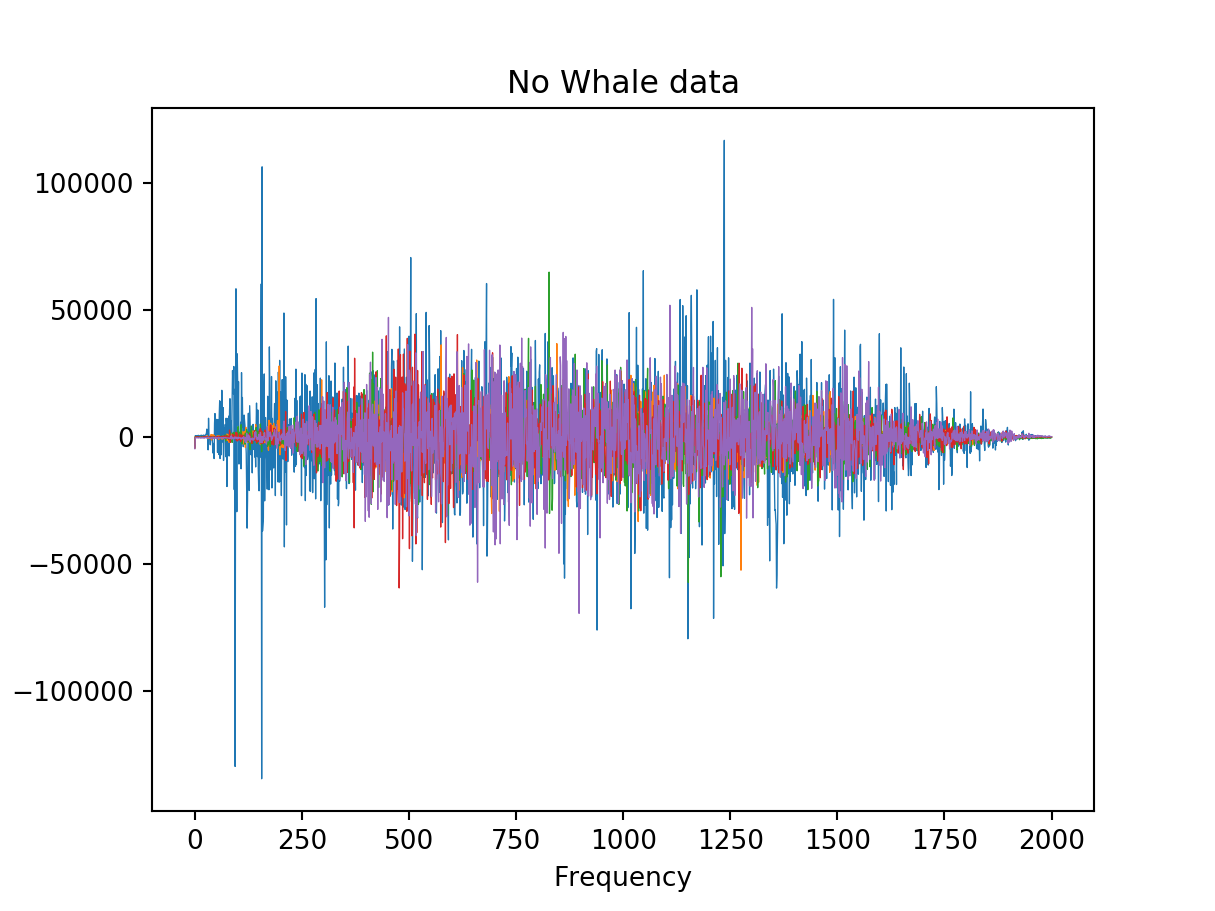

Text(0.5,1,u'No Whale data')

In [78]:
plt.figure()
for array in no_whale_data:
    plt.plot(np.fft.rfft(array), linewidth=0.5)
plt.xlabel('Frequency')
plt.title('No Whale data')

It's not entirely clear where the whale frequency content is, so let's not downsample.

# Processing the Real Data

In [79]:
import os

In [108]:
training_files_folder = "/home/sarah/github/deep-whale/data/train/"
#training_aiff_filenames = os.listdir(training_files_folder)
label_csv_filename = "/home/sarah/github/deep-whale/data/train.csv"

In [109]:
# Load the labels csv
labels_csv = np.genfromtxt(label_csv_filename, dtype=None, delimiter=',', skip_header=1)

In [116]:
# Load the training files as numpy arrays
training_numpy_arrays = []
training_labels = []
#for filename in training_aiff_filenames:
for filename_tuple in labels_csv:
    filename = filename_tuple[0]
    label = filename_tuple[1]
    if label == 0:
        training_labels.append([0,1])
    else:
        training_labels.append([1,0])
    aifc_file = aifc.open(training_files_folder + filename)
    frames = aifc_file.readframes(aifc_file.getnframes())
    training_numpy_arrays.append(np.fromstring(frames, np.short).byteswap())
training_numpy_arrays = np.array(training_numpy_arrays)
training_labels = np.array(training_labels)

In [120]:
training_labels, training_numpy_arrays, training_numpy_arrays.shape

(array([[0, 1],
        [0, 1],
        [0, 1],
        ..., 
        [0, 1],
        [0, 1],
        [0, 1]]), array([[ 303, -140, -166, ...,  194,   65,  402],
        [  74,  200,  -22, ..., -204,  107,  -11],
        [-197,  231,   79, ..., -303,   41,  120],
        ..., 
        [ -47, -535, -349, ..., -122, -233,   -7],
        [-110,  -71,   18, ...,  -88, -190,  -82],
        [-202,  106,  117, ..., -157, -208,  -42]], dtype=int16), (30000,
  4000))

### Save Numpy Timeseries Data

In [119]:
# now save the data
all_data_file = h5py.File("all_whale_training_30000samples_shape4000.hdf5", 'w-')

In [121]:
all_data_file.create_dataset("data", dtype=np.short, shape=training_numpy_arrays.shape)

<HDF5 dataset "data": shape (30000, 4000), type "<i2">

In [122]:
all_data_file['data'][...] = training_numpy_arrays

In [123]:
all_data_file.create_dataset("labels", dtype='i', shape=training_labels.shape)
all_data_file['labels'][...] = training_labels

In [124]:
all_data_file.flush()
all_data_file.close()

## Fourier Transform the Data

In [131]:
real_part = np.fft.rfft(training_numpy_arrays[0]).real
imag_part = np.fft.rfft(training_numpy_arrays[0]).imag

<IPython.core.display.Javascript object>


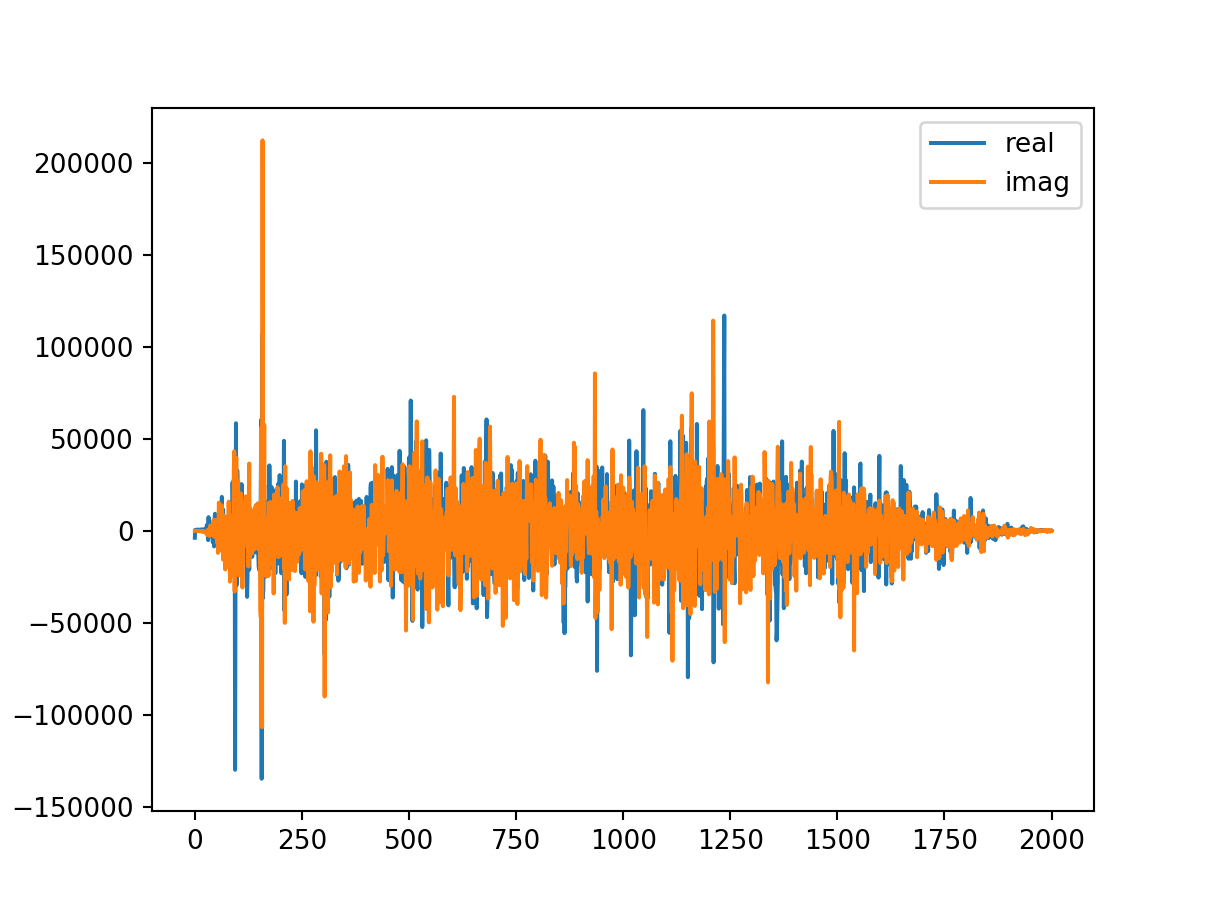

In [132]:
plt.figure()
plt.plot(real_part, label='real')
plt.plot(imag_part, label='imag')
plt.legend()

<IPython.core.display.Javascript object>


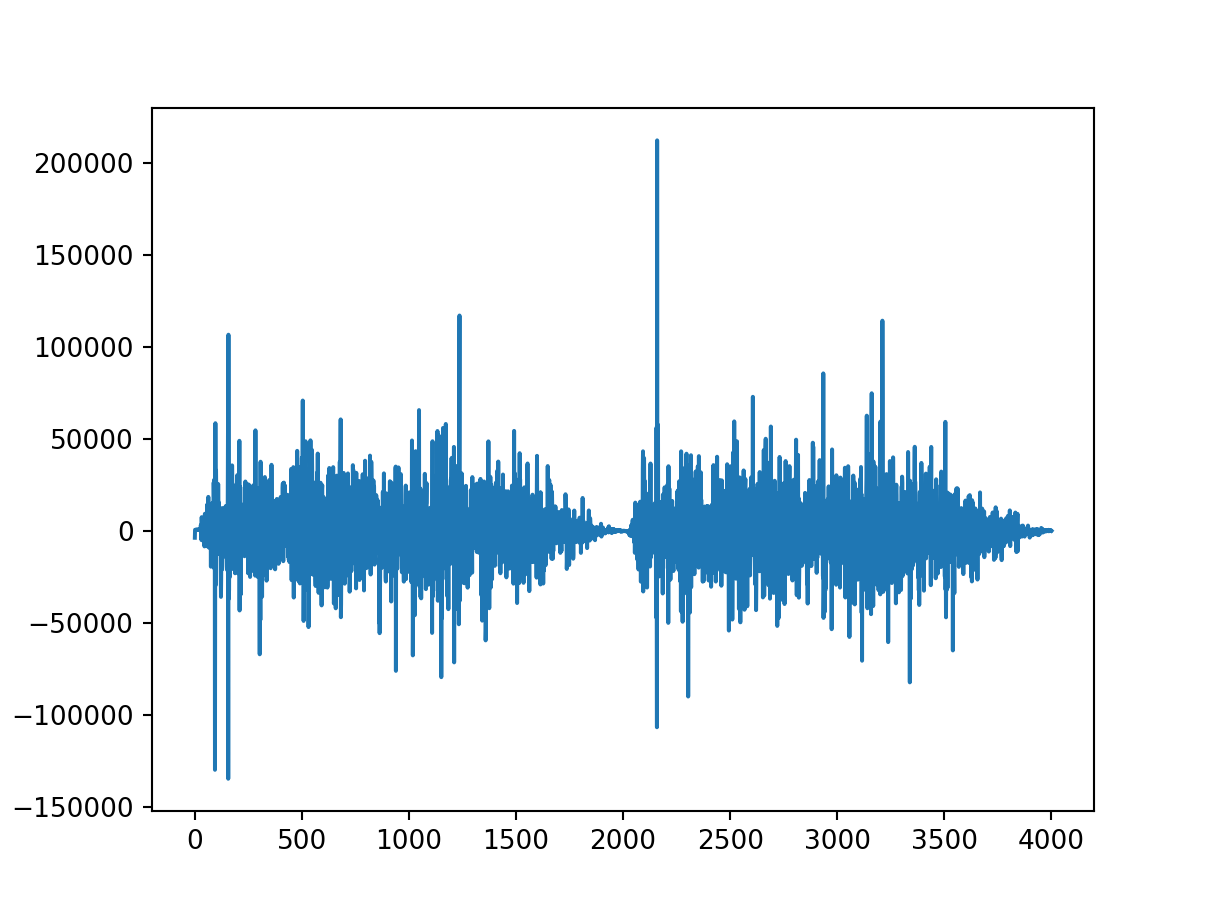

In [134]:
concat_parts = np.concatenate([real_part, imag_part])
plt.figure()
plt.plot(concat_parts)

Prof Z says to NOT append. Just do two different channels. (She said "like tuples")

In [135]:
real_imag_array = np.array([real_part, imag_part])
real_imag_array, real_imag_array.T

(array([[ -3.80700000e+03,   5.19054983e+02,   5.15625455e+02, ...,
          -1.32069745e+02,  -1.80386557e+02,   1.50000000e+01],
        [  0.00000000e+00,  -3.43986299e+00,   3.21757013e+01, ...,
           2.27607732e+02,   6.59898146e+01,   0.00000000e+00]]),
 array([[ -3.80700000e+03,   0.00000000e+00],
        [  5.19054983e+02,  -3.43986299e+00],
        [  5.15625455e+02,   3.21757013e+01],
        ..., 
        [ -1.32069745e+02,   2.27607732e+02],
        [ -1.80386557e+02,   6.59898146e+01],
        [  1.50000000e+01,   0.00000000e+00]]))

In [136]:
training_numpy_ffts = []
for i in range(len(training_numpy_arrays)):
    fft = np.fft.rfft(training_numpy_arrays[i])
    real_part = fft.real
    imag_part = fft.imag
    training_numpy_ffts.append(np.array([real_part, imag_part]).T)
training_numpy_ffts = np.array(training_numpy_ffts)

In [138]:
training_numpy_ffts.shape

(30000, 2001, 2)

### Save Numpy FFT Data

In [139]:
all_fft_data_file = h5py.File("all_whale_training_fft_30000samples_shape2001x2.hdf5", 'w-')

all_fft_data_file.create_dataset("data", dtype=np.short, shape=training_numpy_ffts.shape)
all_fft_data_file['data'][...] = training_numpy_ffts

all_fft_data_file.create_dataset("labels", dtype='i', shape=training_labels.shape)
all_fft_data_file['labels'][...] = training_labels

all_fft_data_file.flush()
all_fft_data_file.close()

## Split into training/validation/test

In [147]:
test_frac = 0.2
(1-test_frac) * 30000, test_frac * 30000

(24000.0, 6000.0)

In [150]:
val_frac = 0.2
(1-val_frac) * (24000.0), val_frac * (24000.0)

(19200.0, 4800.0)

In [2]:
import aifc
import numpy as np
import h5py
from matplotlib import pyplot as plt
%matplotlib notebook

In [3]:
all_fft_data_file = h5py.File("all_whale_training_fft_30000samples_shape2001x2.hdf5", 'r')

In [5]:
all_fft_data_file['labels']

<HDF5 dataset "labels": shape (30000, 2), type "<i4">

In [7]:
flat_labels = []
for i in range(len(all_fft_data_file['labels'])):
    if all_fft_data_file['labels'][i][0] == 1:
        flat_labels.append(1)
    else:
        flat_labels.append(0)


<IPython.core.display.Javascript object>


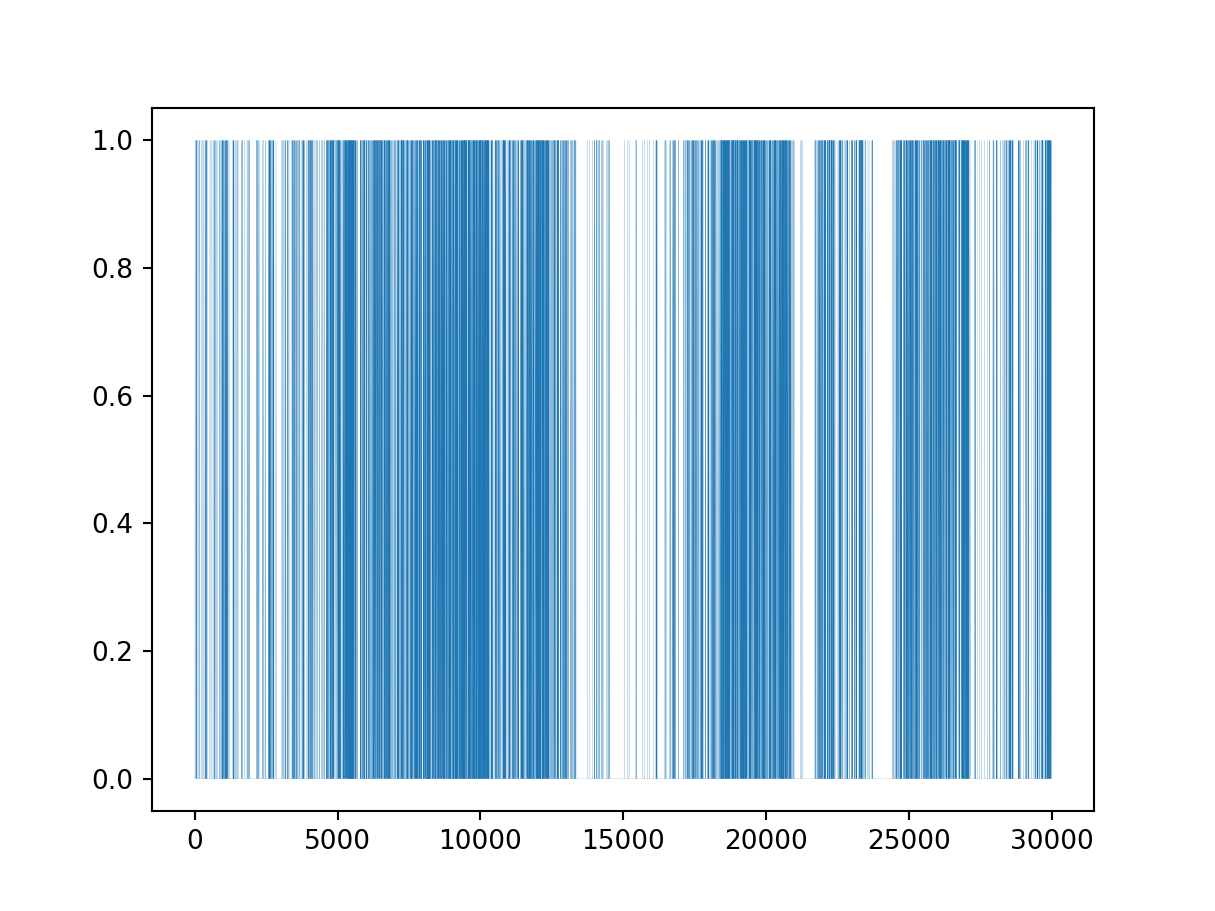

In [14]:
plt.figure()
plt.plot(flat_labels, '-', linewidth=0.05)

In [15]:
#Seems... close enough to randomly distributed

In [16]:
test_indicies = int(0.2 * 30000)
train_indicies = test_indicies + int(0.8 * (0.8 * 30000))
validataion_indicies = train_indicies + int(0.8 * (0.2 * 30000))

In [17]:
test_indicies, train_indicies, validataion_indicies

(6000, 25200, 30000)

In [18]:
# Now split up the data!

# Test data
test_data = []
test_labels = []
for i in range(test_indicies):
    test_data.append(all_fft_data_file['data'][i])
    test_labels.append(all_fft_data_file['labels'][i])
test_data = np.array(test_data)
test_labels = np.array(test_labels)

# Training data 
training_data = []
training_labels = []
for i in range(test_indicies, train_indicies):
    training_data.append(all_fft_data_file['data'][i])
    training_labels.append(all_fft_data_file['labels'][i])
training_data = np.array(training_data)
training_labels = np.array(training_labels)

# Validation data 
validation_data = []
validation_labels = []
for i in range(train_indicies, validataion_indicies):
    validation_data.append(all_fft_data_file['data'][i])
    validation_labels.append(all_fft_data_file['labels'][i])
validation_data = np.array(validation_data)
validation_labels = np.array(validation_labels)

In [21]:
test_data.shape, training_data.shape, validation_data.shape

((6000, 2001, 2), (19200, 2001, 2), (4800, 2001, 2))

In [22]:
# Save the split data

split_fft_data_file = h5py.File("whale_training_fft_samples19200train4800val6000test_shape2001x2.hdf5", 'w-')

split_fft_data_file.create_dataset("training_data", dtype=np.short, shape=training_data.shape)
split_fft_data_file['training_data'][...] = training_data

split_fft_data_file.create_dataset("training_labels", dtype='i', shape=training_labels.shape)
split_fft_data_file['training_labels'][...] = training_labels

split_fft_data_file.create_dataset("validation_data", dtype=np.short, shape=validation_data.shape)
split_fft_data_file['validation_data'][...] = validation_data

split_fft_data_file.create_dataset("validation_labels", dtype='i', shape=validation_labels.shape)
split_fft_data_file['validation_labels'][...] = validation_labels

split_fft_data_file.create_dataset("testing_data", dtype=np.short, shape=test_data.shape)
split_fft_data_file['testing_data'][...] = test_data

split_fft_data_file.create_dataset("testing_labels", dtype='i', shape=test_labels.shape)
split_fft_data_file['testing_labels'][...] = test_labels

split_fft_data_file.flush()
split_fft_data_file.close()